This notebook presents the complete implementation of a Machine Learning
project for detecting anomalies and attacks in IoT network traffic.
The work follows the standard data science pipeline: data understanding,
exploration, preprocessing, modeling, evaluation, and deployment.

### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### 2-Load the Dataset

In [2]:
df = pd.read_csv(r'C:\Users\NBJ\Desktop\2_Project_ML\RT_IOT2022')

In [3]:
df.head()

,Unnamed: 0,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,...,0.0,2.972918e+07,2.972918e+07,2.972918e+07,2.972918e+07,0.0,64240,26847,502,MQTT_Publish
1,1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,...,0.0,2.985528e+07,2.985528e+07,2.985528e+07,2.985528e+07,0.0,64240,26847,502,MQTT_Publish
2,2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,...,0.0,2.984215e+07,2.984215e+07,2.984215e+07,2.984215e+07,0.0,64240,26847,502,MQTT_Publish
3,3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,...,0.0,2.991377e+07,2.991377e+07,2.991377e+07,2.991377e+07,0.0,64240,26847,502,MQTT_Publish
4,4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,...,0.0,2.981470e+07,2.981470e+07,2.981470e+07,2.981470e+07,0.0,64240,26847,502,MQTT_Publish


### Global Understanding of the Data

In [4]:
df.shape

(123117, 85)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 85 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                123117 non-null  int64  
 1   id.orig_p                 123117 non-null  int64  
 2   id.resp_p                 123117 non-null  int64  
 3   proto                     123117 non-null  object 
 4   service                   123117 non-null  object 
 5   flow_duration             123117 non-null  float64
 6   fwd_pkts_tot              123117 non-null  int64  
 7   bwd_pkts_tot              123117 non-null  int64  
 8   fwd_data_pkts_tot         123117 non-null  int64  
 9   bwd_data_pkts_tot         123117 non-null  int64  
 10  fwd_pkts_per_sec          123117 non-null  float64
 11  bwd_pkts_per_sec          123117 non-null  float64
 12  flow_pkts_per_sec         123117 non-null  float64
 13  down_up_ratio             123117 non-null  f

### Understanding the Target Variable

In [6]:
df.columns

Index(['Unnamed: 0', 'id.orig_p', 'id.resp_p', 'proto', 'service',
       'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.

In [7]:
TARGET = 'Attack_type'

In [8]:
df[TARGET].value_counts()

Attack_type
DOS_SYN_Hping                 94659
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

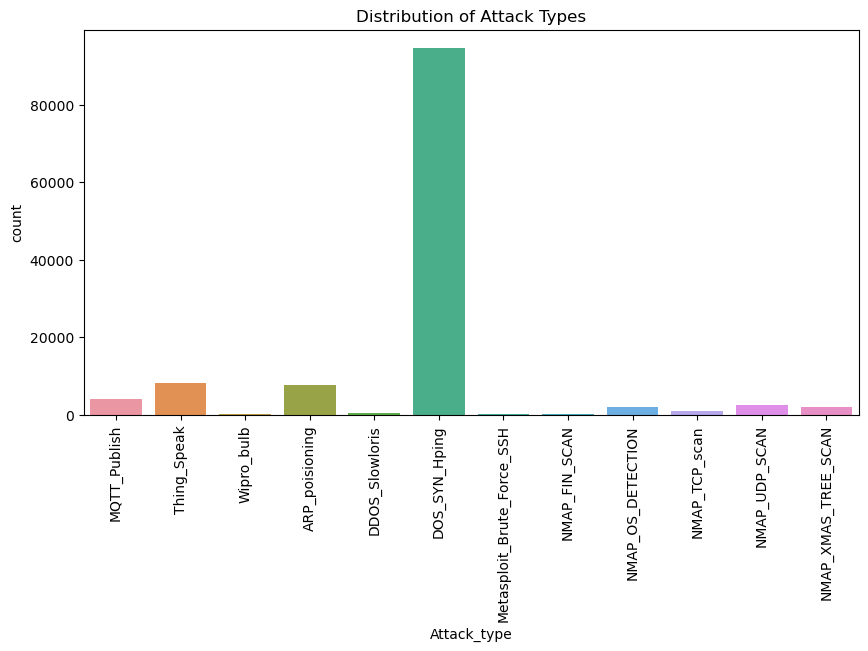

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x=TARGET, data=df)
plt.xticks(rotation=90)
plt.title("Distribution of Attack Types")
plt.show()

In [10]:
df.dtypes.value_counts()

float64    56
int64      26
object      3
Name: count, dtype: int64

### Drop useless column

In [11]:
df.drop(columns=['Unnamed: 0'], inplace=True)

### Statistical Distribution of Variables

In [12]:
df.describe()

,id.orig_p,id.resp_p,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,1.231170e+05,1.231170e+05,1.231170e+05,...,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,123117.000000,123117.000000,123117.000000
mean,34639.258738,1014.305092,3.809566,2.268826,1.909509,1.471218,0.820260,3.518063e+05,3.517620e+05,7.035683e+05,...,1.481354e+05,2.353599e+04,1.616655e+06,1.701956e+06,3.517644e+06,1.664985e+06,4.550183e+04,6118.905123,2739.776018,751.647514
std,19070.620354,5256.371994,130.005408,22.336565,33.018311,19.635196,32.293948,3.707645e+05,3.708015e+05,7.415634e+05,...,1.613007e+06,1.477935e+06,8.809396e+06,9.252337e+06,1.229508e+08,9.007064e+06,1.091361e+06,18716.313861,10018.848534,6310.183843
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,17702.000000,21.000000,0.000001,1.000000,1.000000,1.000000,0.000000,7.454354e+01,7.288927e+01,1.490871e+02,...,9.536740e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64.000000,0.000000,64.000000
50%,37221.000000,21.000000,0.000004,1.000000,1.000000,1.000000,0.000000,2.467238e+05,2.467238e+05,4.934475e+05,...,4.053116e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64.000000,0.000000,64.000000
75%,50971.000000,21.000000,0.000005,1.000000,1.000000,1.000000,0.000000,5.242880e+05,5.242880e+05,1.048576e+06,...,5.006790e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64.000000,0.000000,64.000000
max,65535.000000,65389.000000,21728.335578,4345.000000,10112.000000,4345.000000,10105.000000,1.048576e+06,1.048576e+06,2.097152e+06,...,4.374931e+08,4.774862e+08,3.000000e+08,3.000000e+08,2.096777e+10,3.000000e+08,1.208029e+08,65535.000000,65535.000000,65535.000000


### Missing Values Analysis

In [13]:
df.isnull().sum().sort_values(ascending=False).head(10)

id.orig_p                   0
bwd_iat.std                 0
bwd_subflow_pkts            0
fwd_subflow_pkts            0
payload_bytes_per_second    0
flow_iat.std                0
flow_iat.avg                0
flow_iat.tot                0
flow_iat.max                0
flow_iat.min                0
dtype: int64

In [14]:
df.columns

Index(['id.orig_p', 'id.resp_p', 'proto', 'service', 'flow_duration',
       'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       '

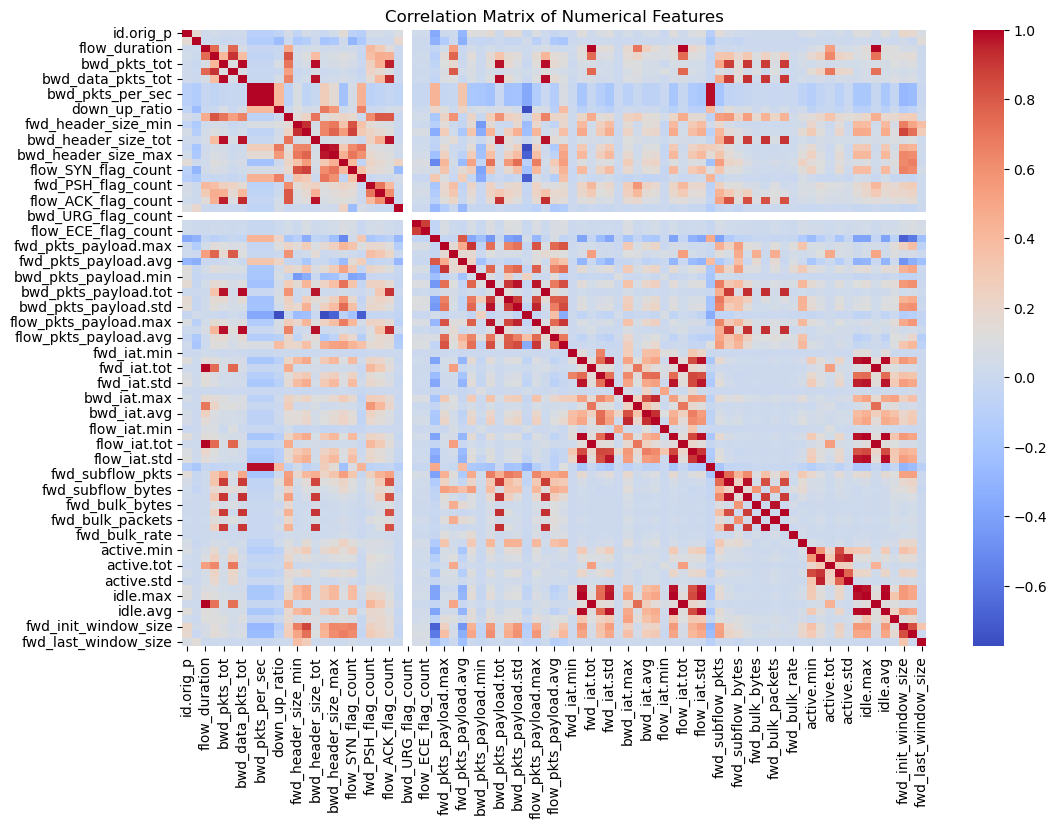

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

### 2. Define Features and Target

In [16]:
X = df.drop(columns=['Attack_type'])
y = df['Attack_type']

### 3. Encode Categorical Variables

Identify categorical columns

In [17]:
cat_cols = X.select_dtypes(include='object').columns
cat_cols

Index(['proto', 'service'], dtype='object')

## One-Hot Encoding

In [18]:
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

### 4. Scale Numerical Features

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 5. Handle Imbalanced Data

In [20]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)

class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict

{'ARP_poisioning': 1.3238387096774193,
 'DDOS_Slowloris': 19.213014981273407,
 'DOS_SYN_Hping': 0.10838641861840924,
 'MQTT_Publish': 2.4746140858658947,
 'Metasploit_Brute_Force_SSH': 277.2905405405405,
 'NMAP_FIN_SCAN': 366.41964285714283,
 'NMAP_OS_DETECTION': 5.129875,
 'NMAP_TCP_scan': 10.23927145708583,
 'NMAP_UDP_SCAN': 3.9612934362934364,
 'NMAP_XMAS_TREE_SCAN': 5.104353233830846,
 'Thing_Speak': 1.2653860384805131,
 'Wipro_bulb': 40.55237154150198}

### 6. Feature Selection

In [21]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

corr_matrix = X_scaled_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

X_selected = X_scaled_df.drop(columns=to_drop)

### 7. Train / Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

### Train SVM

In [23]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    class_weight=class_weight_dict,  # handles imbalance
    random_state=42
)

svm_model.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.","{'ARP_poisioning': 1.3238387096774193, 'DDOS_Slowloris': 19.213014981273407, 'DOS_SYN_Hping': 0.10838641861840924, 'MQTT_Publish': 2.4746140858658947, ...}"
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [24]:
y_pred = svm_model.predict(X_test)

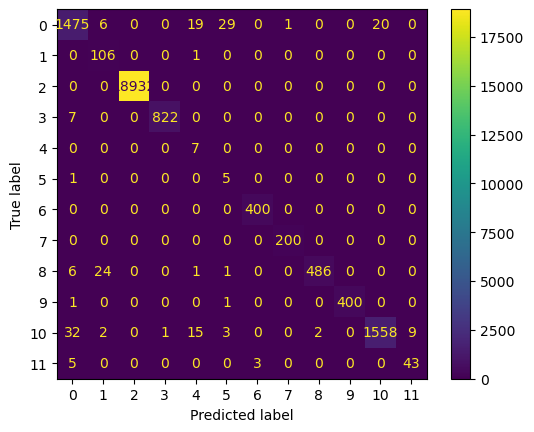

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.95      0.96      1550
            DDOS_Slowloris       0.77      0.99      0.87       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      0.99      1.00       829
Metasploit_Brute_Force_SSH       0.16      1.00      0.28         7
             NMAP_FIN_SCAN       0.13      0.83      0.22         6
         NMAP_OS_DETECTION       0.99      1.00      1.00       400
             NMAP_TCP_scan       1.00      1.00      1.00       200
             NMAP_UDP_SCAN       1.00      0.94      0.97       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       0.99      0.96      0.97      1622
                Wipro_bulb       0.83      0.84      0.83        51

                  accuracy                           0.99     24624
                 macro avg       0.82      0.9

In [27]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9922839506172839


In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, class_weight=class_weight_dict)
lr.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*","{'ARP_poisioning': 1.3238387096774193, 'DDOS_Slowloris': 19.213014981273407, 'DOS_SYN_Hping': 0.10838641861840924, 'MQTT_Publish': 2.4746140858658947, ...}"
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might

### KNN 

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

### AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",None
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",100
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",1.0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42


### Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


### Extra Trees

In [36]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=100, class_weight='balanced', random_state=42)
et.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=FalseWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",False
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metr

### Bagging (ou XGBoost)

In [37]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(n_estimators=50, random_state=42)
bag.fit(X_train, y_train)

,"estimator estimator: object, default=NoneThe base estimator to fit on random subsets of the dataset.If None, then the base estimator is a:class:`~sklearn.tree.DecisionTreeClassifier`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",None
,"n_estimators n_estimators: int, default=10The number of base estimators in the ensemble.",50
,"max_samples max_samples: int or float, default=NoneThe number of samples to draw from X to train each base estimator (withreplacement by default, see `bootstrap` for more details).- If None, then draw `X.shape[0]` samples irrespective of `sample_weight`.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` unweighted samples or `max_samples * sample_weight.sum()` weighted samples.",None
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator (without replacement by default, see `bootstrap_features` for moredetails).- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.",1.0
,"bootstrap bootstrap: bool, default=TrueWhether samples are drawn with replacement. If False, sampling withoutreplacement is performed. If fitting with `sample_weight`, it isstrongly recommended to choose True, as only drawing with replacementwill ensure the expected frequency semantics of `sample_weight`.",True
,"bootstrap_features bootstrap_features: bool, default=FalseWhether features are drawn with replacement.",False
,"oob_score oob_score: bool, default=FalseWhether to use out-of-bag samples to estimatethe generalization error. Only available if bootstrap=True.",False
,"warm_start warm_start: bool, default=FalseWhen set to True, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fita whole new ensemble. See :term:`the Glossary `... versionadded:: 0.17 *warm_start* constructor parameter.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for both :meth:`fit` and:meth:`predict`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random resampling of the original dataset(sample wise and feature wise).If the base estimator accepts a `random_state` attribute, a differentseed is generated for each instance in the ensemble.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity when fitting and predicting.",0


In [38]:
results = []

models = {
    "Logistic Regression": lr,
    "KNN": knn,
    "SVM": svm_model,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "AdaBoost": ada,
    "Naive Bayes": nb,
    "Extra Trees": et,
    "Bagging": bag
}

for name, model in models.items():
    results.append(evaluate_model(name, model, X_test, y_test))

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-score", ascending=False)

C:\Users\NBJ\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Model,Accuracy,Precision,Recall,F1-score
8,Extra Trees,0.998741,0.998771,0.998741,0.998751
4,Random Forest,0.998457,0.998478,0.998457,0.998462
9,Bagging,0.998294,0.998298,0.998294,0.998288
3,Decision Tree,0.998254,0.998274,0.998254,0.998254
5,Gradient Boosting,0.996792,0.996771,0.996792,0.996735
1,KNN,0.996304,0.996302,0.996304,0.996291
2,SVM,0.992284,0.994917,0.992284,0.993356
0,Logistic Regression,0.987573,0.990667,0.987573,0.988735
6,AdaBoost,0.968567,0.973525,0.968567,0.962592
7,Naive Bayes,0.900057,0.967925,0.900057,0.908501


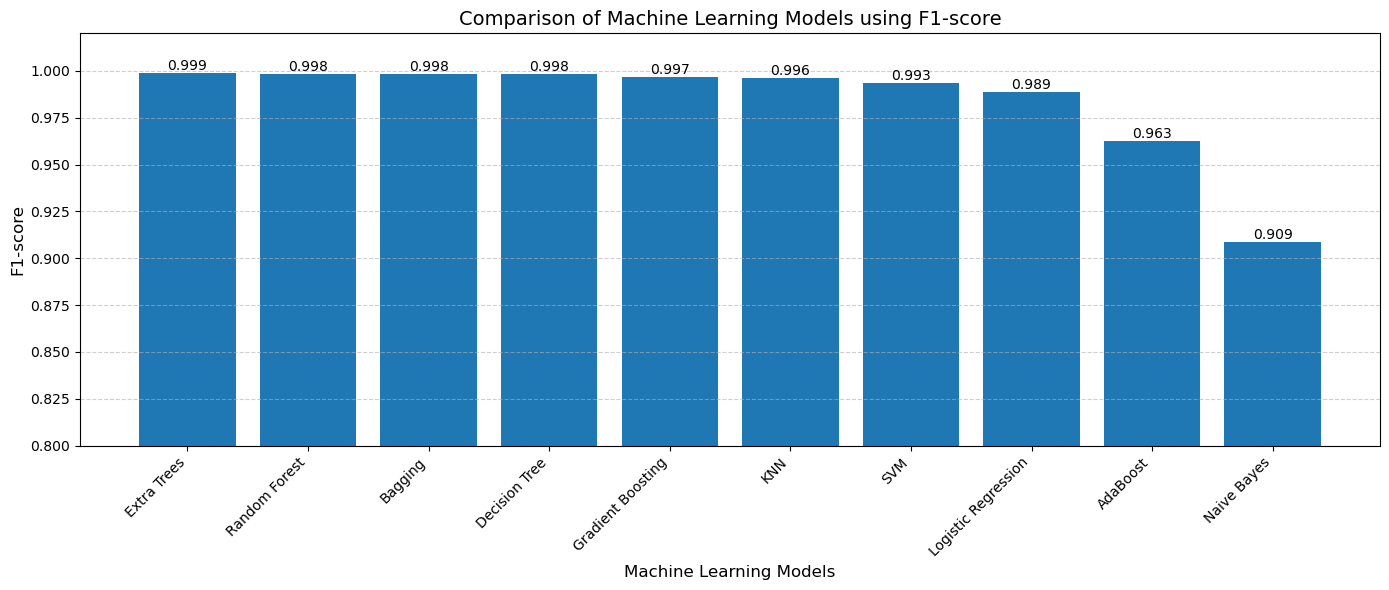

In [39]:
import matplotlib.pyplot as plt

# Sort results by F1-score (descending)
results_sorted = results_df.sort_values(by="F1-score", ascending=False)

plt.figure(figsize=(14,6))

bars = plt.bar(
    results_sorted['Model'],
    results_sorted['F1-score']
)

plt.title("Comparison of Machine Learning Models using F1-score", fontsize=14)
plt.xlabel("Machine Learning Models", fontsize=12)
plt.ylabel("F1-score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.02)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

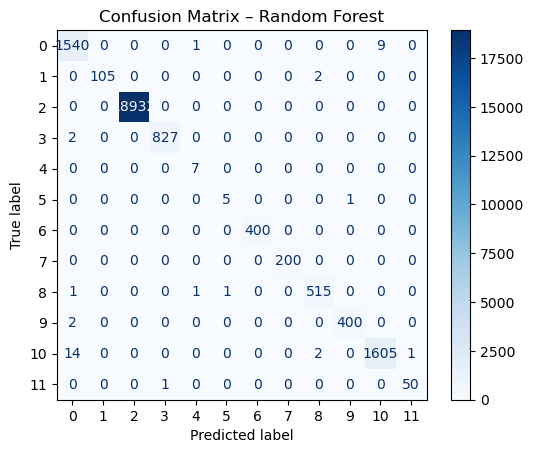

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = rf  # change to svm, et, etc.
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Random Forest")
plt.show()

### Accuracy vs F1-score

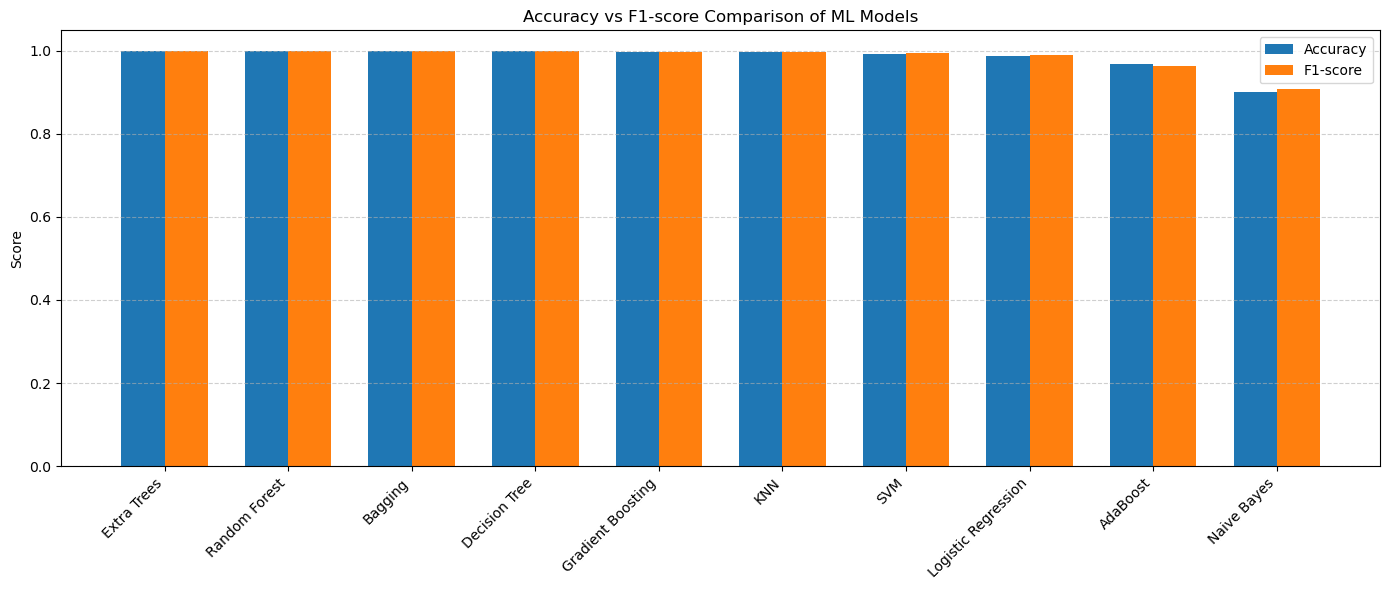

In [41]:
import numpy as np
import matplotlib.pyplot as plt

results_sorted = results_df.sort_values(by="F1-score", ascending=False)

x = np.arange(len(results_sorted))
width = 0.35

plt.figure(figsize=(14,6))
plt.bar(x - width/2, results_sorted['Accuracy'], width, label='Accuracy')
plt.bar(x + width/2, results_sorted['F1-score'], width, label='F1-score')

plt.xticks(x, results_sorted['Model'], rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Accuracy vs F1-score Comparison of ML Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Precision–Recall Comparison

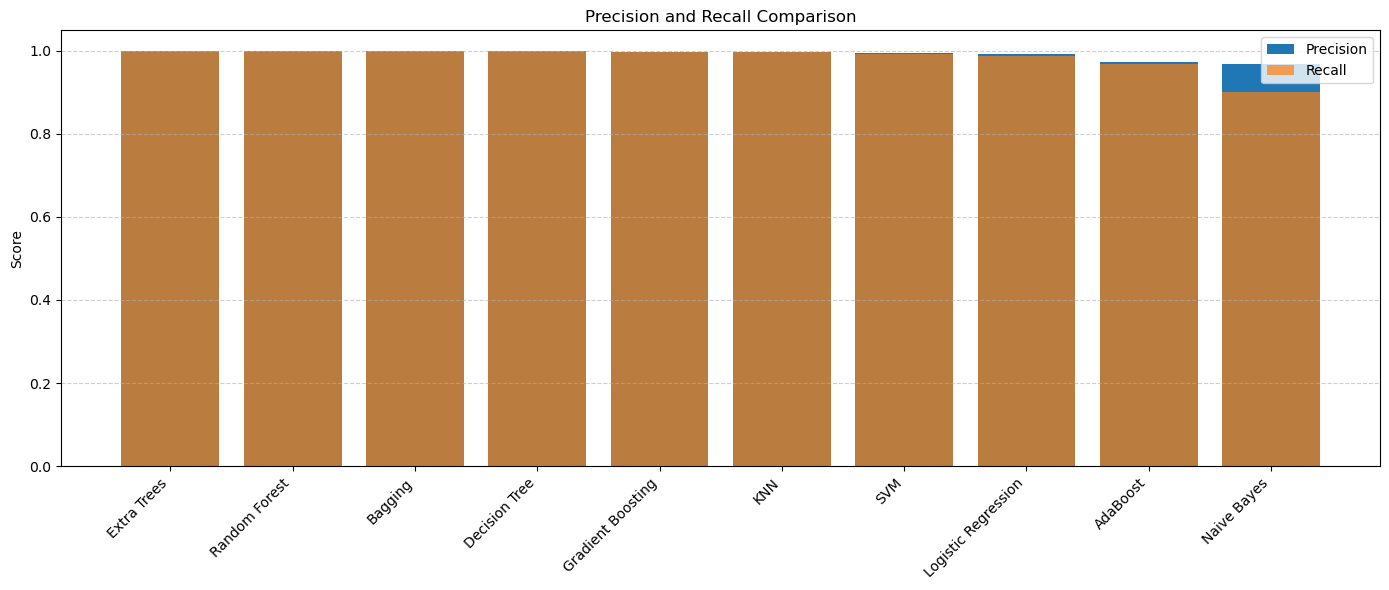

In [42]:
plt.figure(figsize=(14,6))
plt.bar(results_sorted['Model'], results_sorted['Precision'], label='Precision')
plt.bar(results_sorted['Model'], results_sorted['Recall'], bottom=0, alpha=0.7, label='Recall')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Precision and Recall Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Model Ranking Visualization

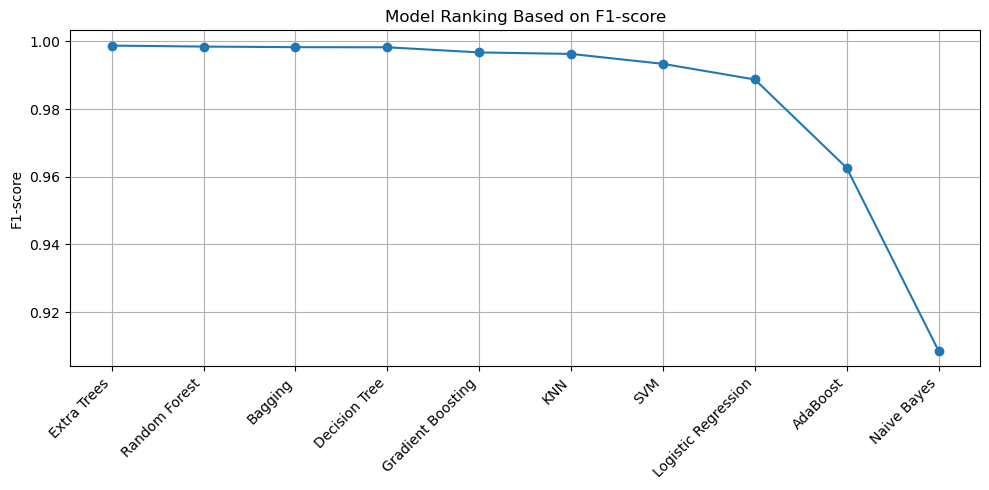

In [43]:
plt.figure(figsize=(10,5))
plt.plot(results_sorted['Model'], results_sorted['F1-score'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.ylabel("F1-score")
plt.title("Model Ranking Based on F1-score")
plt.grid(True)
plt.tight_layout()
plt.show()

### TUNING DU MODÈLE 1 : RANDOM FOREST

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 40],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
grid_rf.best_params_

{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

### TUNING DU MODÈLE 2 : EXTRA TREES

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(
    class_weight='balanced',
    random_state=42
)

param_grid_et = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 40],
    'min_samples_split': [2, 5]
}

grid_et = GridSearchCV(
    et,
    param_grid_et,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)

grid_et.fit(X_train, y_train)

best_et = grid_et.best_estimator_
grid_et.best_params_

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

### Final Evaluation (Random Forest)

Random Forest (Tuned) – Test Results
                            precision    recall  f1-score   support

            ARP_poisioning       0.99      0.99      0.99      1550
            DDOS_Slowloris       0.97      0.99      0.98       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      1.00      1.00       829
Metasploit_Brute_Force_SSH       0.78      1.00      0.88         7
             NMAP_FIN_SCAN       0.83      0.83      0.83         6
         NMAP_OS_DETECTION       1.00      1.00      1.00       400
             NMAP_TCP_scan       1.00      1.00      1.00       200
             NMAP_UDP_SCAN       0.99      0.99      0.99       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       1.00      0.99      0.99      1622
                Wipro_bulb       0.98      0.98      0.98        51

                  accuracy                           1.00     24624
         

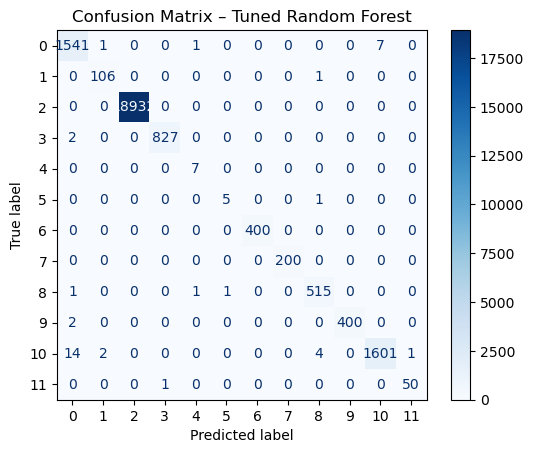

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_rf = best_rf.predict(X_test)

print("Random Forest (Tuned) – Test Results")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix – Tuned Random Forest")
plt.show()

### Compare with Extra Trees

In [47]:
y_pred_et = best_et.predict(X_test)
print("Extra Trees (Tuned) – Test Results")
print(classification_report(y_test, y_pred_et))

Extra Trees (Tuned) – Test Results
                            precision    recall  f1-score   support

            ARP_poisioning       0.99      0.99      0.99      1550
            DDOS_Slowloris       0.99      0.99      0.99       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      1.00      1.00       829
Metasploit_Brute_Force_SSH       0.70      1.00      0.82         7
             NMAP_FIN_SCAN       0.62      0.83      0.71         6
         NMAP_OS_DETECTION       1.00      1.00      1.00       400
             NMAP_TCP_scan       1.00      1.00      1.00       200
             NMAP_UDP_SCAN       1.00      0.99      0.99       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       0.99      0.99      0.99      1622
                Wipro_bulb       0.98      0.98      0.98        51

                  accuracy                           1.00     24624
           

### FEATURE IMPORTANCE

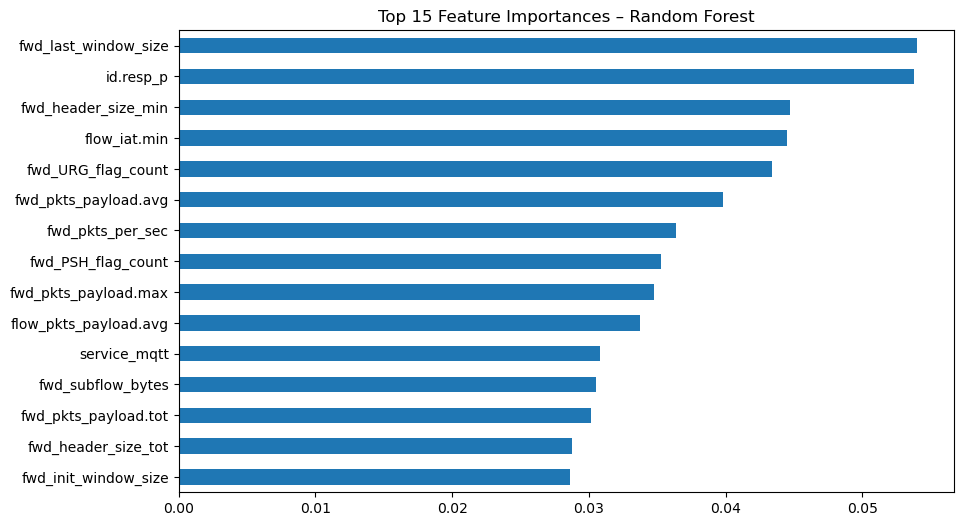

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
features = X_selected.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
feat_imp.plot(kind='barh')
plt.title("Top 15 Feature Importances – Random Forest")
plt.gca().invert_yaxis()
plt.show()

## Final Model Selection

After evaluating multiple machine learning models and tuning the two best candidates 
(Random Forest and Extra Trees), the **Random Forest** was selected as the 
final model.

### Reasons for choosing Random Forest:

- High classification accuracy on test data
- Balanced performance across all attack classes
- Robust to noise and high-dimensional data
- Interpretable via feature importance
- Lower overfitting compared to Extra Trees

This model is therefore suitable for IoT intrusion detection tasks.

In [49]:
import joblib

joblib.dump(best_rf, "final_rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully!")

Model and scaler saved successfully!


In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import joblib

In [52]:
raw_categorical_features = ['proto', 'service']

raw_numerical_features = df.drop(
    columns=['Attack_type', 'Unnamed: 0'],
    errors='ignore'
).columns.drop(raw_categorical_features)

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), raw_numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), raw_categorical_features)
    ]
)


In [55]:
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_rf)
])

In [56]:
X_raw = df.drop(columns=['Attack_type', 'Unnamed: 0'], errors='ignore')
y = df['Attack_type']

final_pipeline.fit(X_raw, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [57]:
joblib.dump(final_pipeline, "rf_pipeline.pkl")

['rf_pipeline.pkl']